In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

9772


In [2]:
import cv2
from tqdm import tqdm

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 396


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:
print(segmentation_save_folder)

\\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation


In [6]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

In [7]:
reload(ia.classes.preprocess)

<module 'ImageAnalysis3.classes.preprocess' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\preprocess.py'>

# Part 1: Only run cellpose

In [9]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(ref_image_file, 
                                                  CorrectionFolder=correction_folder, 
                                                  DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, 
                                              DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_750 = _cls.im_750[0::4]
    _cls.im_488 = _cls.im_488[0::4]
    _cls.im_405 = _cls.im_405[0::4]
    _cls.image_size = np.array(np.shape(_ref_im))
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750], corr_chromatic=False) # removed 405 to increase efficiency
    
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405, microscope_params)
        #dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_405, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=70, 
                                        min_size=2000,
                                        do_3D=True,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = labels3d.copy() # no modification is required for this one.

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    


Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_0.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_1.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_2.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_3.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_4.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_5.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_6.npy

Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_142.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_143.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_144.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_145.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_146.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_147.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation

Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_354.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_355.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_356.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_357.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_358.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation_label_359.npy already exists, skip
Segmentation label file: \\10.245.74.158\Chromatin_NAS_0\20221026-hM1_hM1_Cx28_sample4\Segmentation\segmentation

<IPython.core.display.Javascript object>


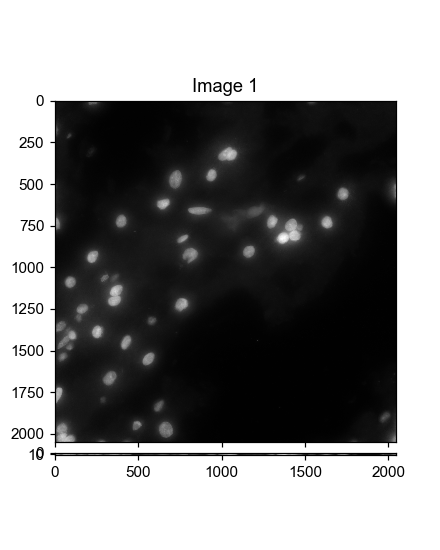

In [9]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, _cls.im_405])

<IPython.core.display.Javascript object>


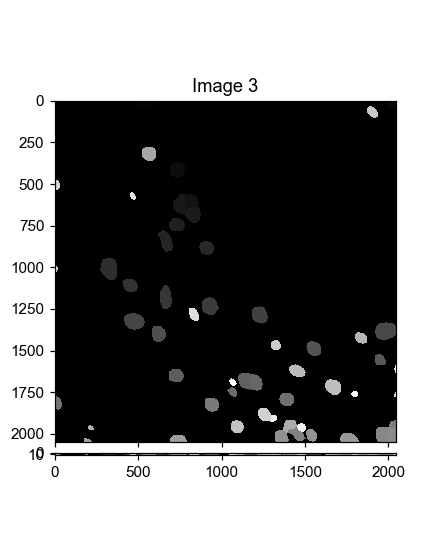

In [10]:
visual_tools.imshow_mark_3d_v2([polyt_im, dapi_im, labels3d])

- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_0.npy


In [12]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
        
    print(f"- Run segmentation for fov: {_fov_id}.")

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_488 = _cls.im_488[0::4]
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750,405], corr_chromatic=False)

    # If file exists, skip
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_405, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
        # reshape
        #test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in dapi_im])
        #test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in polyt_im])
        
        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        batch_size=60, anisotropy=250/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=70, 
                                        min_size=2000,
                                        do_3D=True,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")
        # resize segmentation label back
        corr_labels3d = np.zeros_like(labels3d[0::4])
        for _ix in tqdm(range(np.shape(corr_labels3d)[1])):
            for _iy in range(np.shape(corr_labels3d)[2]):
                for _iz in range(len(corr_labels3d)):
                    corr_labels3d[_iz,_ix,_iy] = np.bincount(labels3d[4*_iz:4*_iz+4,_ix,_iy]).argmax()
        #corr_labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
        #                                interpolation=cv2.INTER_NEAREST_EXACT) 
        #                     for _ly in labels3d])
        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = np.array([np.max(polyt_im[4*_j:4*_j+4],axis=0) for _j in range(int(len(polyt_im)/4)+1)])
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

- Run segmentation for fov: 0.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_000.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_000.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.135s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.114s.
- Finished illumination correction in 1.218s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_000.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:32<00:00, 22.13it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_0.npy
- run watershed in 85.638s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_0.npy
- Run segmentation for fov: 1.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.250s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction in 1

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_1.npy
- run watershed in 81.336s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_1.npy
- Run segmentation for fov: 2.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_002.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_002.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_002.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.937s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_2.npy
- run watershed in 76.981s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_2.npy
- Run segmentation for fov: 3.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_003.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_003.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_003.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.547s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_3.npy
- run watershed in 76.561s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_3.npy
- Run segmentation for fov: 4.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_004.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_004.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_004.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.812s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction in 1

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.67it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_4.npy
- run watershed in 75.869s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_4.npy
- Run segmentation for fov: 5.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_005.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_005.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_005.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.796s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction in 1

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.37it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_5.npy
- run watershed in 79.015s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_5.npy
- Run segmentation for fov: 6.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_006.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_006.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_006.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.375s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction in 1

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.57it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_6.npy
- run watershed in 79.904s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_6.npy
- Run segmentation for fov: 7.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_007.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_007.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_007.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.500s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.50it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_7.npy
- run watershed in 72.167s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_7.npy
- Run segmentation for fov: 8.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_008.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_008.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_008.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.312s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.58it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_8.npy
- run watershed in 65.148s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_8.npy
- Run segmentation for fov: 9.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_009.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_009.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_009.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.437s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction in 1

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.71it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_9.npy
- run watershed in 81.280s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_9.npy
- Run segmentation for fov: 10.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_010.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_010.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_010.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.140s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.58it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_10.npy
- run watershed in 77.854s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_10.npy
- Run segmentation for fov: 11.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_011.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_011.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_011.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_11.npy
- run watershed in 75.034s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_11.npy
- Run segmentation for fov: 12.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_012.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_012.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_012.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.089s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.41it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_12.npy
- run watershed in 77.239s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_12.npy
- Run segmentation for fov: 13.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_013.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_013.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_013.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.48it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_13.npy
- run watershed in 77.504s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_13.npy
- Run segmentation for fov: 14.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_014.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_014.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_014.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.203s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.37it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_14.npy
- run watershed in 76.828s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_14.npy
- Run segmentation for fov: 15.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_015.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_015.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_015.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_15.npy
- run watershed in 81.562s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_15.npy
- Run segmentation for fov: 16.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_016.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_016.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_016.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_16.npy
- run watershed in 80.720s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_16.npy
- Run segmentation for fov: 17.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_017.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_017.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_017.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.61it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_17.npy
- run watershed in 86.208s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_17.npy
- Run segmentation for fov: 18.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_018.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_018.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_018.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.234s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.55it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_18.npy
- run watershed in 87.465s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_18.npy
- Run segmentation for fov: 19.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_019.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_019.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_019.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.26it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_19.npy
- run watershed in 85.418s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_19.npy
- Run segmentation for fov: 20.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_020.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_020.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_020.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.094s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_20.npy
- run watershed in 83.146s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_20.npy
- Run segmentation for fov: 21.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_021.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_021.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_021.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.234s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:37<00:00, 20.94it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_21.npy
- run watershed in 95.644s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_21.npy
- Run segmentation for fov: 22.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_022.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_022.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_022.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.003s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.70it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_22.npy
- run watershed in 83.522s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_22.npy
- Run segmentation for fov: 23.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_023.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_023.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_023.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.234s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.54it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_23.npy
- run watershed in 85.883s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_23.npy
- Run segmentation for fov: 24.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_024.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_024.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_024.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.283s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_24.npy
- run watershed in 68.294s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_24.npy
- Run segmentation for fov: 25.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_025.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_025.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_025.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.203s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.64it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_25.npy
- run watershed in 70.182s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_25.npy
- Run segmentation for fov: 26.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_026.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_026.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_026.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.156s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.40it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_26.npy
- run watershed in 81.077s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_26.npy
- Run segmentation for fov: 27.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_027.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_027.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_027.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.234s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_27.npy
- run watershed in 88.610s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_27.npy
- Run segmentation for fov: 28.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_028.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_028.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_028.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.156s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_28.npy
- run watershed in 73.942s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_28.npy
- Run segmentation for fov: 29.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_029.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_029.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_029.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.194s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.48it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_29.npy
- run watershed in 81.671s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_29.npy
- Run segmentation for fov: 30.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_030.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_030.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_030.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.25it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_30.npy
- run watershed in 85.204s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_30.npy
- Run segmentation for fov: 31.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_031.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_031.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_031.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.138s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.29it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_31.npy
- run watershed in 79.697s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_31.npy
- Run segmentation for fov: 32.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_032.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_032.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_032.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.125s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.24it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_32.npy
- run watershed in 70.792s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_32.npy
- Run segmentation for fov: 33.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_033.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_033.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_033.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_33.npy
- run watershed in 79.792s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_33.npy
- Run segmentation for fov: 34.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_034.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_034.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_034.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.43it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_34.npy
- run watershed in 85.620s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_34.npy
- Run segmentation for fov: 35.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_035.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_035.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_035.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.017s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_35.npy
- run watershed in 83.327s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_35.npy
- Run segmentation for fov: 36.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_036.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_036.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_036.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.328s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_36.npy
- run watershed in 95.174s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_36.npy
- Run segmentation for fov: 37.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_037.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_037.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_037.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.69it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_37.npy
- run watershed in 85.463s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_37.npy
- Run segmentation for fov: 38.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_038.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_038.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_038.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.187s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.068s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.21it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_38.npy
- run watershed in 83.115s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_38.npy
- Run segmentation for fov: 39.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_039.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_039.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_039.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.422s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.45it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_39.npy
- run watershed in 87.593s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_39.npy
- Run segmentation for fov: 40.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_040.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_040.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_040.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.080s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_40.npy
- run watershed in 81.748s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_40.npy
- Run segmentation for fov: 41.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_041.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_041.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_041.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_41.npy
- run watershed in 85.501s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_41.npy
- Run segmentation for fov: 42.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_042.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_042.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_042.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.094s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_42.npy
- run watershed in 64.505s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_42.npy
- Run segmentation for fov: 43.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_043.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_043.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_043.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.43it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_43.npy
- run watershed in 83.276s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_43.npy
- Run segmentation for fov: 44.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_044.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_044.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_044.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.065s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.29it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_44.npy
- run watershed in 84.161s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_44.npy
- Run segmentation for fov: 45.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_045.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_045.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_045.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.312s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.27it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_45.npy
- run watershed in 88.623s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_45.npy
- Run segmentation for fov: 46.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_046.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_046.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_046.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.32it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_46.npy
- run watershed in 80.464s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_46.npy
- Run segmentation for fov: 47.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_047.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_047.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_047.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.203s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.44it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_47.npy
- run watershed in 88.840s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_47.npy
- Run segmentation for fov: 48.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_048.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_048.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_048.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.62it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_48.npy
- run watershed in 96.539s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_48.npy
- Run segmentation for fov: 49.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_049.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_049.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_049.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.312s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.62it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_49.npy
- run watershed in 94.981s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_49.npy
- Run segmentation for fov: 50.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_050.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_050.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_050.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.250s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.37it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_50.npy
- run watershed in 82.556s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_50.npy
- Run segmentation for fov: 51.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_051.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_051.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_051.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.034s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.60it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_51.npy
- run watershed in 83.872s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_51.npy
- Run segmentation for fov: 52.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_052.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_052.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_052.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_52.npy
- run watershed in 82.657s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_52.npy
- Run segmentation for fov: 53.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_053.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_053.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_053.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.125s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_53.npy
- run watershed in 78.621s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_53.npy
- Run segmentation for fov: 54.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_054.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_054.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_054.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.172s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.59it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_54.npy
- run watershed in 90.765s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_54.npy
- Run segmentation for fov: 55.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_055.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_055.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_055.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.172s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.49it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_55.npy
- run watershed in 85.650s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_55.npy
- Run segmentation for fov: 56.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_056.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_056.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_056.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.064s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.45it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_56.npy
- run watershed in 80.752s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_56.npy
- Run segmentation for fov: 57.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_057.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_057.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_057.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.156s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.41it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_57.npy
- run watershed in 78.293s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_57.npy
- Run segmentation for fov: 58.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_058.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_058.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_058.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.126s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.27it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_58.npy
- run watershed in 80.775s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_58.npy
- Run segmentation for fov: 59.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_059.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_059.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_059.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.064s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_59.npy
- run watershed in 73.183s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_59.npy
- Run segmentation for fov: 60.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_060.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_060.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_060.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.156s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.114s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.41it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_60.npy
- run watershed in 76.856s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_60.npy
- Run segmentation for fov: 61.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_061.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_061.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_061.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.109s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_61.npy
- run watershed in 84.715s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_61.npy
- Run segmentation for fov: 62.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_062.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_062.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_062.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.49it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_62.npy
- run watershed in 80.094s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_62.npy
- Run segmentation for fov: 63.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_063.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_063.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_063.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_63.npy
- run watershed in 77.480s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_63.npy
- Run segmentation for fov: 64.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_064.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_064.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_064.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.406s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.66it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_64.npy
- run watershed in 69.481s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_64.npy
- Run segmentation for fov: 65.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_065.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_065.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_065.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.218s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_65.npy
- run watershed in 65.054s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_65.npy
- Run segmentation for fov: 66.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_066.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_066.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_066.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.064s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.47it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_66.npy
- run watershed in 74.452s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_66.npy
- Run segmentation for fov: 67.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_067.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_067.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_067.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.125s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.110s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_67.npy
- run watershed in 85.090s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_67.npy
- Run segmentation for fov: 68.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_068.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_068.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_068.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.63it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_68.npy
- run watershed in 79.524s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_68.npy
- Run segmentation for fov: 69.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_069.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_069.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_069.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.437s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.51it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_69.npy
- run watershed in 84.149s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_69.npy
- Run segmentation for fov: 70.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_070.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_070.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_070.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.140s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_70.npy
- run watershed in 86.280s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_70.npy
- Run segmentation for fov: 71.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_071.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_071.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_071.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.071s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.60it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_71.npy
- run watershed in 89.014s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_71.npy
- Run segmentation for fov: 72.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_072.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_072.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_072.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.140s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_72.npy
- run watershed in 82.828s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_72.npy
- Run segmentation for fov: 73.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_073.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_073.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_073.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.281s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.68it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_73.npy
- run watershed in 80.386s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_73.npy
- Run segmentation for fov: 74.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_074.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_074.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_074.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.189s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_74.npy
- run watershed in 83.910s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_74.npy
- Run segmentation for fov: 75.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_075.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_075.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_075.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.54it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_75.npy
- run watershed in 71.797s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_75.npy
- Run segmentation for fov: 76.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_076.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_076.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_076.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.250s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.65it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_76.npy
- run watershed in 76.734s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_76.npy
- Run segmentation for fov: 77.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_077.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_077.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_077.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.140s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.43it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_77.npy
- run watershed in 73.495s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_77.npy
- Run segmentation for fov: 78.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_078.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_078.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_078.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.46it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_78.npy
- run watershed in 82.647s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_78.npy
- Run segmentation for fov: 79.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_079.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_079.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_079.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.218s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_79.npy
- run watershed in 78.275s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_79.npy
- Run segmentation for fov: 80.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_080.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_080.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_080.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.62it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_80.npy
- run watershed in 74.433s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_80.npy
- Run segmentation for fov: 81.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_081.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_081.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_081.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.250s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.59it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_81.npy
- run watershed in 68.231s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_81.npy
- Run segmentation for fov: 82.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_082.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_082.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_082.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.187s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.47it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_82.npy
- run watershed in 80.028s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_82.npy
- Run segmentation for fov: 83.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_083.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_083.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_083.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.027s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.32it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_83.npy
- run watershed in 71.619s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_83.npy
- Run segmentation for fov: 84.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_084.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_084.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_084.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.343s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.55it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_84.npy
- run watershed in 74.847s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_84.npy
- Run segmentation for fov: 85.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_085.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_085.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_085.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.501s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_85.npy
- run watershed in 81.835s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_85.npy
- Run segmentation for fov: 86.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_086.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_086.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_086.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.24it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_86.npy
- run watershed in 67.873s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_86.npy
- Run segmentation for fov: 87.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_087.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_087.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_087.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.67it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_87.npy
- run watershed in 79.368s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_87.npy
- Run segmentation for fov: 88.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_088.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_088.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_088.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.172s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.46it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_88.npy
- run watershed in 91.002s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_88.npy
- Run segmentation for fov: 89.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_089.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_089.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_089.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.63it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_89.npy
- run watershed in 81.462s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_89.npy
- Run segmentation for fov: 90.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_090.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_090.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_090.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.437s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.73it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_90.npy
- run watershed in 76.235s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_90.npy
- Run segmentation for fov: 91.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_091.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_091.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_091.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.265s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.32it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_91.npy
- run watershed in 72.718s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_91.npy
- Run segmentation for fov: 92.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_092.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_092.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_092.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.250s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_92.npy
- run watershed in 80.907s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_92.npy
- Run segmentation for fov: 93.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_093.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_093.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_093.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.140s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.49it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_93.npy
- run watershed in 86.892s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_93.npy
- Run segmentation for fov: 94.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_094.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_094.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_094.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.49it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_94.npy
- run watershed in 73.856s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_94.npy
- Run segmentation for fov: 95.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_095.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_095.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_095.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_95.npy
- run watershed in 82.375s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_95.npy
- Run segmentation for fov: 96.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_096.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_096.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_096.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_96.npy
- run watershed in 83.986s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_96.npy
- Run segmentation for fov: 97.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_097.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_097.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_097.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.203s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.31it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_97.npy
- run watershed in 80.942s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_97.npy
- Run segmentation for fov: 98.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_098.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_098.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_098.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.315s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.54it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_98.npy
- run watershed in 90.854s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_98.npy
- Run segmentation for fov: 99.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_099.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_099.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_099.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.297s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction i

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_99.npy
- run watershed in 81.616s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_99.npy
- Run segmentation for fov: 100.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_100.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_100.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_100.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.107s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction 

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.59it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_100.npy
- run watershed in 80.492s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_100.npy
- Run segmentation for fov: 101.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_101.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_101.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_101.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.985s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.58it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_101.npy
- run watershed in 85.072s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_101.npy
- Run segmentation for fov: 102.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_102.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_102.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_102.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_102.npy
- run watershed in 86.070s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_102.npy
- Run segmentation for fov: 103.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_103.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_103.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_103.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.109s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_103.npy
- run watershed in 82.108s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_103.npy
- Run segmentation for fov: 104.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_104.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_104.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_104.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.297s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.23it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_104.npy
- run watershed in 83.221s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_104.npy
- Run segmentation for fov: 105.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_105.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_105.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_105.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.41it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_105.npy
- run watershed in 89.471s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_105.npy
- Run segmentation for fov: 106.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_106.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_106.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_106.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.203s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.30it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_106.npy
- run watershed in 85.243s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_106.npy
- Run segmentation for fov: 107.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_107.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_107.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_107.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.109s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_107.npy
- run watershed in 80.796s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_107.npy
- Run segmentation for fov: 108.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_108.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_108.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_108.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.31it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_108.npy
- run watershed in 75.618s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_108.npy
- Run segmentation for fov: 109.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_109.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_109.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_109.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.080s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.27it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_109.npy
- run watershed in 85.609s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_109.npy
- Run segmentation for fov: 110.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_110.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_110.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_110.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.29it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_110.npy
- run watershed in 79.930s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_110.npy
- Run segmentation for fov: 111.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_111.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_111.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_111.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.187s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.50it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_111.npy
- run watershed in 78.440s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_111.npy
- Run segmentation for fov: 112.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_112.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_112.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_112.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.250s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.54it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_112.npy
- run watershed in 82.978s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_112.npy
- Run segmentation for fov: 113.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_113.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_113.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_113.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.376s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.51it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_113.npy
- run watershed in 80.631s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_113.npy
- Run segmentation for fov: 114.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_114.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_114.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_114.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.080s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_114.npy
- run watershed in 82.807s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_114.npy
- Run segmentation for fov: 115.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_115.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_115.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_115.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.49it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_115.npy
- run watershed in 88.419s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_115.npy
- Run segmentation for fov: 116.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_116.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_116.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_116.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.140s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.31it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_116.npy
- run watershed in 90.301s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_116.npy
- Run segmentation for fov: 117.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_117.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_117.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_117.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.30it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_117.npy
- run watershed in 91.296s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_117.npy
- Run segmentation for fov: 118.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_118.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_118.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_118.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.188s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.52it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_118.npy
- run watershed in 88.845s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_118.npy
- Run segmentation for fov: 119.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_119.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_119.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_119.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_119.npy
- run watershed in 85.061s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_119.npy
- Run segmentation for fov: 120.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_120.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_120.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_120.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_120.npy
- run watershed in 78.068s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_120.npy
- Run segmentation for fov: 121.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_121.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_121.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_121.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.046s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_121.npy
- run watershed in 80.963s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_121.npy
- Run segmentation for fov: 122.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_122.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_122.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_122.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.187s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.082s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_122.npy
- run watershed in 92.219s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_122.npy
- Run segmentation for fov: 123.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_123.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_123.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_123.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.22it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_123.npy
- run watershed in 80.788s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_123.npy
- Run segmentation for fov: 124.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_124.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_124.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_124.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.49it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_124.npy
- run watershed in 80.844s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_124.npy
- Run segmentation for fov: 125.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_125.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_125.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_125.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.106s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_125.npy
- run watershed in 66.787s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_125.npy
- Run segmentation for fov: 126.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_126.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_126.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_126.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_126.npy
- run watershed in 77.373s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_126.npy
- Run segmentation for fov: 127.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_127.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_127.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_127.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.30it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_127.npy
- run watershed in 79.937s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_127.npy
- Run segmentation for fov: 128.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_128.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_128.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_128.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.250s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.43it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_128.npy
- run watershed in 83.593s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_128.npy
- Run segmentation for fov: 129.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_129.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_129.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_129.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.079s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.60it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_129.npy
- run watershed in 78.058s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_129.npy
- Run segmentation for fov: 130.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_130.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_130.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_130.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.906s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.26it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_130.npy
- run watershed in 89.020s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_130.npy
- Run segmentation for fov: 131.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_131.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_131.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_131.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.265s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_131.npy
- run watershed in 80.321s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_131.npy
- Run segmentation for fov: 132.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_132.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_132.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_132.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.26it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_132.npy
- run watershed in 83.442s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_132.npy
- Run segmentation for fov: 133.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_133.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_133.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_133.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.126s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:37<00:00, 21.09it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_133.npy
- run watershed in 92.863s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_133.npy
- Run segmentation for fov: 134.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_134.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_134.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_134.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 3.104s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:38<00:00, 20.82it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_134.npy
- run watershed in 92.214s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_134.npy
- Run segmentation for fov: 135.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_135.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_135.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_135.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 3.001s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.59it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_135.npy
- run watershed in 92.089s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_135.npy
- Run segmentation for fov: 136.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_136.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_136.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_136.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.766s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.064s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.40it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_136.npy
- run watershed in 90.329s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_136.npy
- Run segmentation for fov: 137.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_137.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_137.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_137.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.859s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.28it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_137.npy
- run watershed in 97.594s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_137.npy
- Run segmentation for fov: 138.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_138.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_138.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_138.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 4.157s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:31<00:00, 22.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_138.npy
- run watershed in 84.486s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_138.npy
- Run segmentation for fov: 139.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_139.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_139.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_139.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 3.938s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_139.npy
- run watershed in 78.494s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_139.npy
- Run segmentation for fov: 140.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_140.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_140.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_140.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 3.702s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.21it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_140.npy
- run watershed in 86.771s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_140.npy
- Run segmentation for fov: 141.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_141.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_141.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_141.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 3.109s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_141.npy
- run watershed in 81.373s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_141.npy
- Run segmentation for fov: 142.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_142.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_142.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_142.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 3.563s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.068s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_142.npy
- run watershed in 85.680s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_142.npy
- Run segmentation for fov: 143.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_143.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_143.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_143.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 3.265s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_143.npy
- run watershed in 84.123s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_143.npy
- Run segmentation for fov: 144.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_144.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_144.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_144.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.767s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.60it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_144.npy
- run watershed in 86.856s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_144.npy
- Run segmentation for fov: 145.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_145.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_145.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_145.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.203s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.44it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_145.npy
- run watershed in 88.157s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_145.npy
- Run segmentation for fov: 146.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_146.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_146.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_146.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.704s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.44it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_146.npy
- run watershed in 88.066s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_146.npy
- Run segmentation for fov: 147.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_147.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_147.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_147.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.562s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.110s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_147.npy
- run watershed in 90.002s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_147.npy
- Run segmentation for fov: 148.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_148.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_148.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_148.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.265s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.28it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_148.npy
- run watershed in 89.807s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_148.npy
- Run segmentation for fov: 149.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_149.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_149.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_149.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 4.233s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.59it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_149.npy
- run watershed in 87.374s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_149.npy
- Run segmentation for fov: 150.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_150.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_150.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_150.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.968s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_150.npy
- run watershed in 89.985s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_150.npy
- Run segmentation for fov: 151.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_151.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_151.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_151.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.955s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.50it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_151.npy
- run watershed in 81.015s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_151.npy
- Run segmentation for fov: 152.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_152.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_152.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_152.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.31it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_152.npy
- run watershed in 88.845s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_152.npy
- Run segmentation for fov: 153.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_153.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_153.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_153.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_153.npy
- run watershed in 84.208s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_153.npy
- Run segmentation for fov: 154.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_154.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_154.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_154.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.977s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.085s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.29it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_154.npy
- run watershed in 81.648s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_154.npy
- Run segmentation for fov: 155.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_155.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_155.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_155.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.017s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_155.npy
- run watershed in 88.310s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_155.npy
- Run segmentation for fov: 156.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_156.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_156.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_156.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_156.npy
- run watershed in 85.734s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_156.npy
- Run segmentation for fov: 157.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_157.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_157.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_157.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.968s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.080s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.37it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_157.npy
- run watershed in 79.744s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_157.npy
- Run segmentation for fov: 158.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_158.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_158.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_158.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_158.npy
- run watershed in 81.014s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_158.npy
- Run segmentation for fov: 159.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_159.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_159.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_159.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_159.npy
- run watershed in 74.972s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_159.npy
- Run segmentation for fov: 160.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_160.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_160.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_160.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.020s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.32it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_160.npy
- run watershed in 76.243s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_160.npy
- Run segmentation for fov: 161.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_161.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_161.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_161.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_161.npy
- run watershed in 79.110s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_161.npy
- Run segmentation for fov: 162.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_162.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_162.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_162.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.987s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.63it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_162.npy
- run watershed in 79.273s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_162.npy
- Run segmentation for fov: 163.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_163.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_163.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_163.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.53it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_163.npy
- run watershed in 77.289s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_163.npy
- Run segmentation for fov: 164.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_164.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_164.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_164.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.52it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_164.npy
- run watershed in 77.341s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_164.npy
- Run segmentation for fov: 165.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_165.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_165.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_165.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.922s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.32it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_165.npy
- run watershed in 81.825s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_165.npy
- Run segmentation for fov: 166.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_166.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_166.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_166.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.25it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_166.npy
- run watershed in 86.564s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_166.npy
- Run segmentation for fov: 167.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_167.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_167.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_167.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.72it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_167.npy
- run watershed in 71.707s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_167.npy
- Run segmentation for fov: 168.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_168.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_168.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_168.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.49it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_168.npy
- run watershed in 82.937s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_168.npy
- Run segmentation for fov: 169.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_169.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_169.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_169.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.54it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_169.npy
- run watershed in 80.914s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_169.npy
- Run segmentation for fov: 170.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_170.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_170.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_170.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.49it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_170.npy
- run watershed in 77.877s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_170.npy
- Run segmentation for fov: 171.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_171.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_171.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_171.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.63it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_171.npy
- run watershed in 80.775s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_171.npy
- Run segmentation for fov: 172.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_172.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_172.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_172.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.281s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:31<00:00, 22.45it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_172.npy
- run watershed in 82.358s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_172.npy
- Run segmentation for fov: 173.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_173.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_173.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_173.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.937s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.43it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_173.npy
- run watershed in 87.809s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_173.npy
- Run segmentation for fov: 174.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_174.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_174.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_174.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.43it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_174.npy
- run watershed in 74.012s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_174.npy
- Run segmentation for fov: 175.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_175.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_175.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_175.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.970s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.28it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_175.npy
- run watershed in 80.009s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_175.npy
- Run segmentation for fov: 176.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_176.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_176.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_176.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_176.npy
- run watershed in 82.597s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_176.npy
- Run segmentation for fov: 177.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_177.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_177.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_177.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_177.npy
- run watershed in 84.441s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_177.npy
- Run segmentation for fov: 178.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_178.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_178.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_178.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_178.npy
- run watershed in 84.603s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_178.npy
- Run segmentation for fov: 179.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_179.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_179.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_179.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.48it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_179.npy
- run watershed in 85.816s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_179.npy
- Run segmentation for fov: 180.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_180.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_180.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_180.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.32it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_180.npy
- run watershed in 95.597s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_180.npy
- Run segmentation for fov: 181.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_181.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_181.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_181.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.40it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_181.npy
- run watershed in 89.687s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_181.npy
- Run segmentation for fov: 182.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_182.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_182.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_182.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.28it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_182.npy
- run watershed in 95.910s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_182.npy
- Run segmentation for fov: 183.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_183.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_183.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_183.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.343s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.56it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_183.npy
- run watershed in 92.827s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_183.npy
- Run segmentation for fov: 184.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_184.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_184.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_184.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.048s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.60it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_184.npy
- run watershed in 76.492s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_184.npy
- Run segmentation for fov: 185.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_185.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_185.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_185.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.47it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_185.npy
- run watershed in 81.906s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_185.npy
- Run segmentation for fov: 186.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_186.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_186.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_186.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.50it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_186.npy
- run watershed in 86.614s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_186.npy
- Run segmentation for fov: 187.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_187.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_187.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_187.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.968s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.40it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_187.npy
- run watershed in 91.066s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_187.npy
- Run segmentation for fov: 188.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_188.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_188.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_188.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.125s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.15it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_188.npy
- run watershed in 97.161s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_188.npy
- Run segmentation for fov: 189.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_189.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_189.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_189.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.43it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_189.npy
- run watershed in 88.280s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_189.npy
- Run segmentation for fov: 190.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_190.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_190.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_190.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.54it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_190.npy
- run watershed in 85.278s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_190.npy
- Run segmentation for fov: 191.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_191.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_191.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_191.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.29it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_191.npy
- run watershed in 83.253s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_191.npy
- Run segmentation for fov: 192.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_192.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_192.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_192.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.080s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_192.npy
- run watershed in 87.098s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_192.npy
- Run segmentation for fov: 193.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_193.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_193.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_193.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.47it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_193.npy
- run watershed in 90.404s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_193.npy
- Run segmentation for fov: 194.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_194.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_194.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_194.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.218s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_194.npy
- run watershed in 92.539s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_194.npy
- Run segmentation for fov: 195.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_195.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_195.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_195.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.45it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_195.npy
- run watershed in 93.055s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_195.npy
- Run segmentation for fov: 196.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_196.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_196.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_196.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.58it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_196.npy
- run watershed in 85.681s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_196.npy
- Run segmentation for fov: 197.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_197.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_197.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_197.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.63it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_197.npy
- run watershed in 92.273s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_197.npy
- Run segmentation for fov: 198.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_198.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_198.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_198.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.484s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.60it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_198.npy
- run watershed in 84.234s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_198.npy
- Run segmentation for fov: 199.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_199.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_199.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_199.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.453s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_199.npy
- run watershed in 91.493s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_199.npy
- Run segmentation for fov: 200.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_200.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_200.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_200.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.073s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.37it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_200.npy
- run watershed in 89.668s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_200.npy
- Run segmentation for fov: 201.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_201.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_201.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_201.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_201.npy
- run watershed in 82.642s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_201.npy
- Run segmentation for fov: 202.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_202.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_202.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_202.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.033s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_202.npy
- run watershed in 82.589s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_202.npy
- Run segmentation for fov: 203.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_203.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_203.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_203.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.109s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_203.npy
- run watershed in 84.379s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_203.npy
- Run segmentation for fov: 204.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_204.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_204.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_204.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.033s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_204.npy
- run watershed in 90.611s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_204.npy
- Run segmentation for fov: 205.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_205.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_205.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_205.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.156s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_205.npy
- run watershed in 75.337s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_205.npy
- Run segmentation for fov: 206.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_206.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_206.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_206.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_206.npy
- run watershed in 56.899s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_206.npy
- Run segmentation for fov: 207.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_207.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_207.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_207.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.57it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_207.npy
- run watershed in 78.297s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_207.npy
- Run segmentation for fov: 208.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_208.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_208.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_208.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.45it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_208.npy
- run watershed in 74.907s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_208.npy
- Run segmentation for fov: 209.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_209.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_209.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_209.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.31it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_209.npy
- run watershed in 86.391s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_209.npy
- Run segmentation for fov: 210.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_210.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_210.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_210.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.049s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_210.npy
- run watershed in 86.519s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_210.npy
- Run segmentation for fov: 211.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_211.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_211.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_211.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_211.npy
- run watershed in 83.124s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_211.npy
- Run segmentation for fov: 212.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_212.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_212.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_212.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.985s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.61it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_212.npy
- run watershed in 79.922s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_212.npy
- Run segmentation for fov: 213.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_213.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_213.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_213.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:41<00:00, 20.26it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_213.npy
- run watershed in 82.606s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_213.npy
- Run segmentation for fov: 214.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_214.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_214.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_214.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.437s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_214.npy
- run watershed in 76.825s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_214.npy
- Run segmentation for fov: 215.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_215.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_215.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_215.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.18it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_215.npy
- run watershed in 86.729s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_215.npy
- Run segmentation for fov: 216.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_216.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_216.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_216.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.45it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_216.npy
- run watershed in 89.347s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_216.npy
- Run segmentation for fov: 217.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_217.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_217.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_217.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.22it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_217.npy
- run watershed in 76.674s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_217.npy
- Run segmentation for fov: 218.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_218.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_218.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_218.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.41it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_218.npy
- run watershed in 66.641s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_218.npy
- Run segmentation for fov: 219.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_219.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_219.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_219.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.41it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_219.npy
- run watershed in 73.551s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_219.npy
- Run segmentation for fov: 220.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_220.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_220.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_220.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.922s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.26it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_220.npy
- run watershed in 85.716s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_220.npy
- Run segmentation for fov: 221.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_221.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_221.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_221.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.49it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_221.npy
- run watershed in 81.214s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_221.npy
- Run segmentation for fov: 222.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_222.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_222.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_222.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.086s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_222.npy
- run watershed in 84.112s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_222.npy
- Run segmentation for fov: 223.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_223.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_223.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_223.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:31<00:00, 22.29it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_223.npy
- run watershed in 82.776s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_223.npy
- Run segmentation for fov: 224.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_224.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_224.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_224.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.129s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.31it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_224.npy
- run watershed in 84.848s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_224.npy
- Run segmentation for fov: 225.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_225.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_225.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_225.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:32<00:00, 22.21it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_225.npy
- run watershed in 77.768s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_225.npy
- Run segmentation for fov: 226.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_226.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_226.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_226.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.017s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:31<00:00, 22.27it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_226.npy
- run watershed in 83.822s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_226.npy
- Run segmentation for fov: 227.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_227.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_227.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_227.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.079s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:32<00:00, 22.26it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_227.npy
- run watershed in 83.685s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_227.npy
- Run segmentation for fov: 228.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_228.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_228.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_228.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.018s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.61it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_228.npy
- run watershed in 85.773s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_228.npy
- Run segmentation for fov: 229.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_229.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_229.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_229.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.64it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_229.npy
- run watershed in 79.989s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_229.npy
- Run segmentation for fov: 230.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_230.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_230.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_230.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.080s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_230.npy
- run watershed in 83.810s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_230.npy
- Run segmentation for fov: 231.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_231.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_231.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_231.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_231.npy
- run watershed in 77.926s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_231.npy
- Run segmentation for fov: 232.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_232.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_232.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_232.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.68it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_232.npy
- run watershed in 72.834s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_232.npy
- Run segmentation for fov: 233.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_233.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_233.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_233.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.049s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.72it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_233.npy
- run watershed in 83.264s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_233.npy
- Run segmentation for fov: 234.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_234.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_234.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_234.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.43it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_234.npy
- run watershed in 86.819s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_234.npy
- Run segmentation for fov: 235.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_235.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_235.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_235.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.54it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_235.npy
- run watershed in 77.972s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_235.npy
- Run segmentation for fov: 236.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_236.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_236.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_236.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.094s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_236.npy
- run watershed in 75.240s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_236.npy
- Run segmentation for fov: 237.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_237.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_237.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_237.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.049s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.30it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_237.npy
- run watershed in 76.597s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_237.npy
- Run segmentation for fov: 238.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_238.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_238.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_238.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.079s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.40it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_238.npy
- run watershed in 87.448s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_238.npy
- Run segmentation for fov: 239.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_239.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_239.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_239.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.125s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_239.npy
- run watershed in 85.994s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_239.npy
- Run segmentation for fov: 240.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_240.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_240.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_240.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.40it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_240.npy
- run watershed in 78.557s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_240.npy
- Run segmentation for fov: 241.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_241.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_241.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_241.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_241.npy
- run watershed in 73.426s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_241.npy
- Run segmentation for fov: 242.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_242.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_242.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_242.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.33it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_242.npy
- run watershed in 81.004s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_242.npy
- Run segmentation for fov: 243.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_243.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_243.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_243.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.26it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_243.npy
- run watershed in 81.143s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_243.npy
- Run segmentation for fov: 244.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_244.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_244.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_244.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.44it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_244.npy
- run watershed in 80.988s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_244.npy
- Run segmentation for fov: 245.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_245.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_245.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_245.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.125s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.20it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_245.npy
- run watershed in 81.301s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_245.npy
- Run segmentation for fov: 246.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_246.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_246.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_246.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.47it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_246.npy
- run watershed in 77.923s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_246.npy
- Run segmentation for fov: 247.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_247.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_247.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_247.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.084s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.65it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_247.npy
- run watershed in 89.065s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_247.npy
- Run segmentation for fov: 248.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_248.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_248.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_248.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_248.npy
- run watershed in 78.940s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_248.npy
- Run segmentation for fov: 249.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_249.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_249.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_249.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.578s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.43it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_249.npy
- run watershed in 76.647s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_249.npy
- Run segmentation for fov: 250.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_250.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_250.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_250.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.106s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.30it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_250.npy
- run watershed in 86.740s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_250.npy
- Run segmentation for fov: 251.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_251.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_251.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_251.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.59it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_251.npy
- run watershed in 74.581s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_251.npy
- Run segmentation for fov: 252.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_252.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_252.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_252.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_252.npy
- run watershed in 83.768s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_252.npy
- Run segmentation for fov: 253.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_253.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_253.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_253.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.187s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.27it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_253.npy
- run watershed in 79.973s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_253.npy
- Run segmentation for fov: 254.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_254.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_254.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_254.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.143s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.26it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_254.npy
- run watershed in 78.148s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_254.npy
- Run segmentation for fov: 255.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_255.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_255.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_255.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.48it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_255.npy
- run watershed in 84.644s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_255.npy
- Run segmentation for fov: 256.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_256.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_256.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_256.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.328s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.61it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_256.npy
- run watershed in 85.351s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_256.npy
- Run segmentation for fov: 257.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_257.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_257.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_257.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.095s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.63it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_257.npy
- run watershed in 80.754s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_257.npy
- Run segmentation for fov: 258.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_258.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_258.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_258.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.110s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.50it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_258.npy
- run watershed in 87.130s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_258.npy
- Run segmentation for fov: 259.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_259.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_259.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_259.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.515s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:31<00:00, 22.35it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_259.npy
- run watershed in 87.036s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_259.npy
- Run segmentation for fov: 260.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_260.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_260.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_260.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.079s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.48it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_260.npy
- run watershed in 77.867s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_260.npy
- Run segmentation for fov: 261.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_261.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_261.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_261.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.048s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.47it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_261.npy
- run watershed in 81.449s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_261.npy
- Run segmentation for fov: 262.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_262.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_262.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_262.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.40it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_262.npy
- run watershed in 68.572s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_262.npy
- Run segmentation for fov: 263.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_263.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_263.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_263.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.156s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.44it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_263.npy
- run watershed in 73.632s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_263.npy
- Run segmentation for fov: 264.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_264.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_264.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_264.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.095s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.50it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_264.npy
- run watershed in 73.836s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_264.npy
- Run segmentation for fov: 265.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_265.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_265.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_265.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_265.npy
- run watershed in 87.088s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_265.npy
- Run segmentation for fov: 266.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_266.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_266.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_266.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.52it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_266.npy
- run watershed in 84.484s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_266.npy
- Run segmentation for fov: 267.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_267.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_267.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_267.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.21it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_267.npy
- run watershed in 79.838s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_267.npy
- Run segmentation for fov: 268.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_268.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_268.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_268.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_268.npy
- run watershed in 84.663s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_268.npy
- Run segmentation for fov: 269.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_269.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_269.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_269.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_269.npy
- run watershed in 80.138s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_269.npy
- Run segmentation for fov: 270.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_270.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_270.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_270.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.957s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.080s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:31<00:00, 22.31it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_270.npy
- run watershed in 74.090s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_270.npy
- Run segmentation for fov: 271.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_271.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_271.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_271.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.047s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:33<00:00, 21.85it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_271.npy
- run watershed in 76.060s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_271.npy
- Run segmentation for fov: 272.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_272.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_272.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_272.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:31<00:00, 22.30it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_272.npy
- run watershed in 77.682s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_272.npy
- Run segmentation for fov: 273.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_273.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_273.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_273.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.41it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_273.npy
- run watershed in 79.414s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_273.npy
- Run segmentation for fov: 274.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_274.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_274.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_274.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.59it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_274.npy
- run watershed in 77.959s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_274.npy
- Run segmentation for fov: 275.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_275.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_275.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_275.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.46it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_275.npy
- run watershed in 82.225s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_275.npy
- Run segmentation for fov: 276.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_276.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_276.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_276.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.970s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.77it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_276.npy
- run watershed in 88.819s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_276.npy
- Run segmentation for fov: 277.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_277.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_277.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_277.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.31it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_277.npy
- run watershed in 86.508s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_277.npy
- Run segmentation for fov: 278.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_278.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_278.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_278.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.32it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_278.npy
- run watershed in 79.759s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_278.npy
- Run segmentation for fov: 279.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_279.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_279.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_279.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.76it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_279.npy
- run watershed in 79.408s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_279.npy
- Run segmentation for fov: 280.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_280.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_280.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_280.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.66it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_280.npy
- run watershed in 82.662s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_280.npy
- Run segmentation for fov: 281.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_281.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_281.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_281.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.064s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.40it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_281.npy
- run watershed in 85.387s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_281.npy
- Run segmentation for fov: 282.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_282.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_282.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_282.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.954s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:36<00:00, 21.30it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_282.npy
- run watershed in 90.605s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_282.npy
- Run segmentation for fov: 283.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_283.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_283.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_283.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.34it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_283.npy
- run watershed in 86.945s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_283.npy
- Run segmentation for fov: 284.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_284.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_284.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_284.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.125s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_284.npy
- run watershed in 94.034s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_284.npy
- Run segmentation for fov: 285.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_285.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_285.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_285.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.38it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_285.npy
- run watershed in 79.816s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_285.npy
- Run segmentation for fov: 286.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_286.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_286.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_286.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.424s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_286.npy
- run watershed in 87.613s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_286.npy
- Run segmentation for fov: 287.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_287.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_287.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_287.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.51it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_287.npy
- run watershed in 77.240s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_287.npy
- Run segmentation for fov: 288.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_288.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_288.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_288.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.002s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.39it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_288.npy
- run watershed in 73.642s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_288.npy
- Run segmentation for fov: 289.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_289.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_289.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_289.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.033s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.47it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_289.npy
- run watershed in 65.375s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_289.npy
- Run segmentation for fov: 290.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_290.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_290.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_290.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.48it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_290.npy
- run watershed in 63.547s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_290.npy
- Run segmentation for fov: 291.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_291.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_291.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_291.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.406s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:34<00:00, 21.60it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_291.npy
- run watershed in 78.169s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_291.npy
- Run segmentation for fov: 292.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_292.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_292.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_292.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.54it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_292.npy
- run watershed in 88.629s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_292.npy
- Run segmentation for fov: 293.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_293.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_293.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_293.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.36it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_293.npy
- run watershed in 96.554s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_293.npy
- Run segmentation for fov: 294.
\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_294.dax \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_294.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_294.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correctio

100%|██████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:35<00:00, 21.42it/s]


- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_294.npy
- run watershed in 94.037s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_294.npy


# Transfer segmentation labels for MERLin

In [ ]:
### TODO

<IPython.core.display.Javascript object>


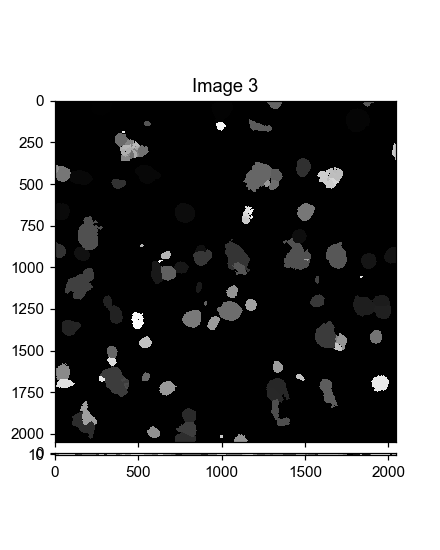

In [42]:
visual_tools.imshow_mark_3d_v2([water_input_im, corr_labels3d, new_labels])

<IPython.core.display.Javascript object>


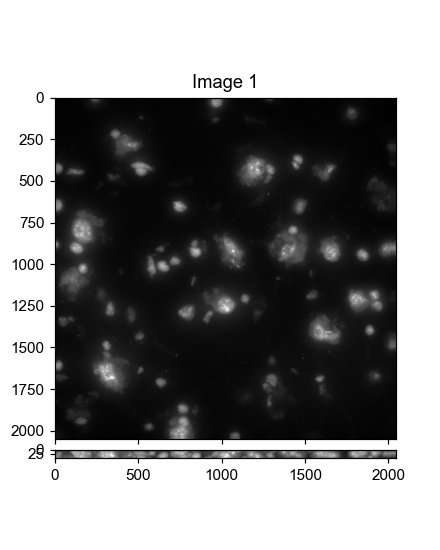

In [39]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask])

<IPython.core.display.Javascript object>


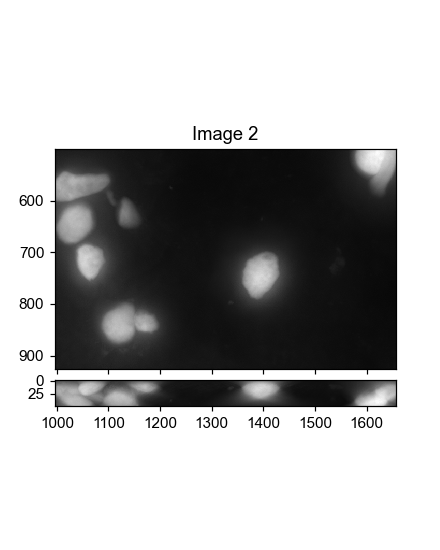

In [23]:
visual_tools.imshow_mark_3d_v2([_cls.im_750, _cls.im_405])

## Check result

<IPython.core.display.Javascript object>


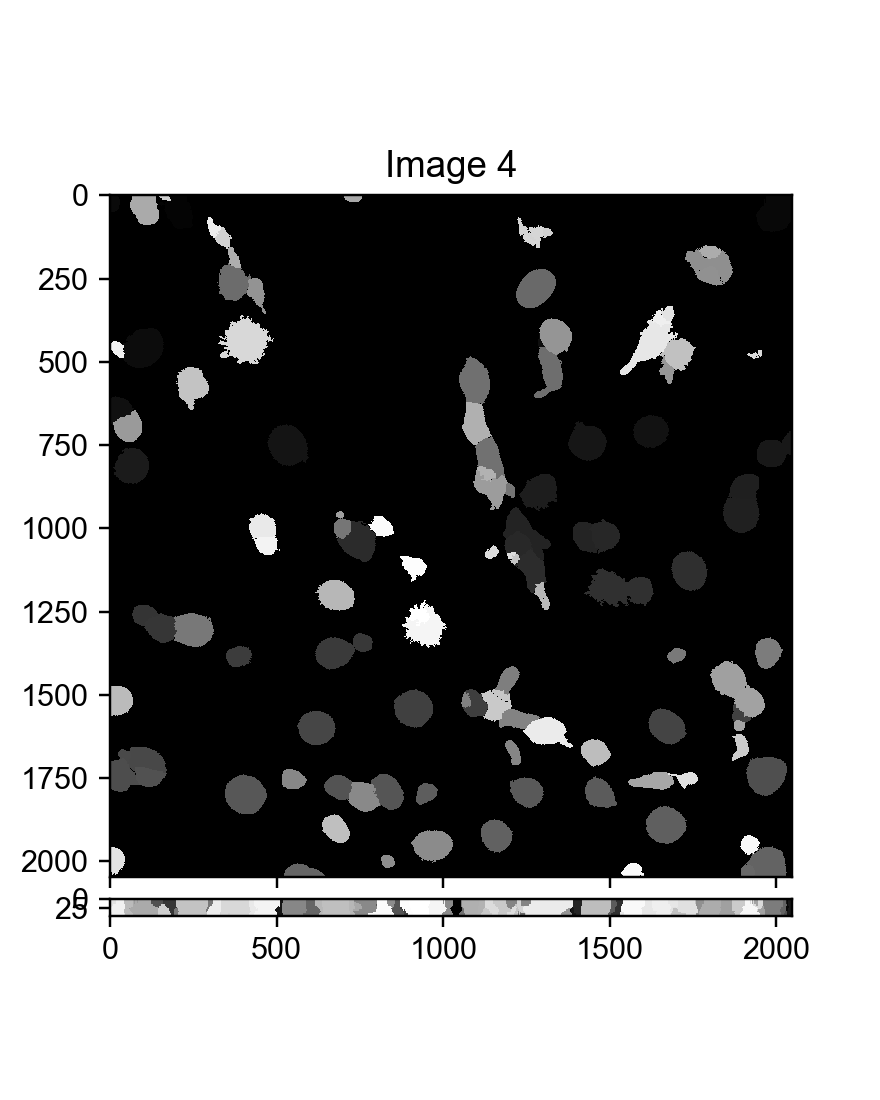

In [12]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, polyt_im, corr_labels3d, new_labels])

# check merlin outputs

In [14]:
import h5py

In [66]:
merlin_feature_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220525-hSTG_test\CellPoseSegment\features\feature_data_0.hdf5'
with h5py.File(merlin_feature_file, 'r') as _f:
    print(_f['labeldata'].keys())
    watershed_labels = _f['labeldata']['label3D'][:]

<KeysViewHDF5 ['label3D']>


<IPython.core.display.Javascript object>


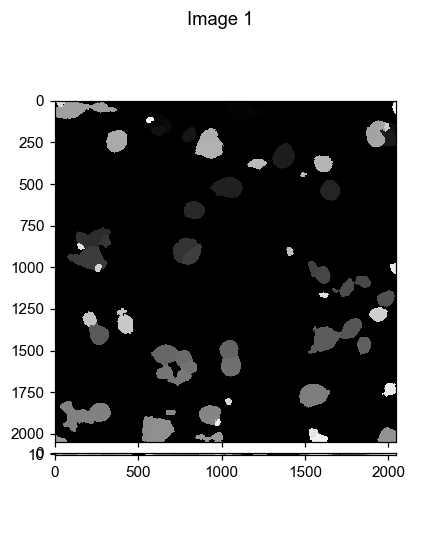

In [67]:
visual_tools.imshow_mark_3d_v2([watershed_labels])

In [8]:
merlin_feature_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220525-hSTG\CellPoseSegment\features\feature_data_80.hdf5'
with h5py.File(merlin_feature_file, 'r') as _f:
    print(_f['labeldata'].keys())
    new_watershed_labels = _f['labeldata']['label3D'][:]

<KeysViewHDF5 ['label3D']>


In [46]:
from skimage import segmentation

new_labels = segmentation.watershed(
                waterIm, old_label3d, mask=waterMask,
                connectivity=np.ones((3, 3, 3)), watershed_line=True)

<IPython.core.display.Javascript object>


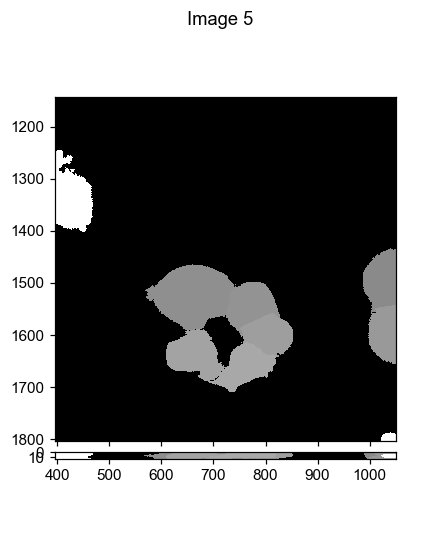

In [47]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask, old_label3d, new_labels])

In [71]:
relabel_info = pickle.load(open(r'E:\Processed_Data_Backup\202003_IMR90_chr2_repeat_relabelling\picked_relabeled_spot_pairs_2-71.pkl','rb'))

In [ ]:
visual_tools

In [85]:
relabe_zxys

array([[[2.44868031e+03, 4.69997054e+03, 7.23436359e+03, 7.48437071e+00],
        [3.73104439e+03, 4.62864729e+03, 7.40921924e+03, 2.39197063e+00],
        [2.24792957e+03, 4.69036958e+03, 7.14845435e+03, 1.58881152e+00],
        ...,
        [2.64051418e+03, 3.11798666e+03, 6.11022821e+03, 9.19883347e+00],
        [2.63617077e+03, 3.07044704e+03, 6.22241441e+03, 7.41383934e+00],
        [2.26103153e+03, 3.21625182e+03, 6.25290601e+03, 3.86180091e+00]],

       [[2.16445065e+03, 3.13107282e+03, 1.01894727e+04, 8.00683212e+00],
        [3.10189037e+03, 4.85165479e+03, 1.02543698e+04, 5.19267321e+00],
        [2.81243649e+03, 4.97361086e+03, 1.03899894e+04, 2.71444392e+00],
        ...,
        [2.79996834e+03, 3.67189906e+03, 1.06949391e+04, 2.33186173e+00],
        [2.76656399e+03, 3.55870226e+03, 1.10467400e+04, 4.68488646e+00],
        [2.73376083e+03, 3.81614900e+03, 1.05940896e+04, 1.11110854e+00]],

       [[2.97902107e+03, 1.35271961e+04, 9.24907709e+03, 2.12193418e+00],
        

In [83]:
relabe_zxys = np.load(r'\\10.245.74.158\Chromatin_NAS_4\2020_cell_materials\Chromatin_Share\Repicked_chromosome_data\before_20200512\zxyhs_final_EM_chr21_relabel.npy')

In [82]:
relabel_info['old'][1][0]

array([[ 0.00000000e+00,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.88830070e+01,  2.29775448e+01,  1.74338776e+02, ...,
        -6.78960886e-03, -6.34057760e-01,  5.79653076e+02],
       ...,
       [ 2.60387554e+01,  2.41951199e+01,  1.68056412e+02, ...,
         1.13709886e-02,  8.33605453e-02,  6.47226807e+02],
       [ 4.13785648e+00,  2.30000000e+01,  1.66000000e+02, ...,
         2.44903816e-07,  4.09684958e-07,  4.69725189e+02],
       [ 1.32260017e+01,  2.31380005e+01,  1.71030380e+02, ...,
         4.81985718e-01, -4.74240720e-01,  3.35760864e+02]])

In [79]:
len(relabel_info['old'][1][0])

357

In [78]:
len(relabel_info['new'][0][0])

357

In [46]:
!dir ..\..\S

 Volume in drive E is Data_01
 Volume Serial Number is B8F1-585C

 Directory of E:\Users\puzheng\Documents

05/28/2022  01:00 AM    <DIR>          .
05/28/2022  01:00 AM    <DIR>          ..
10/20/2020  12:30 AM    <DIR>          Chromatin_Analysis_2020_cell
05/26/2022  04:03 PM    <DIR>          Chromatin_Analysis_Scripts
10/20/2020  12:23 AM    <DIR>          Codes
05/26/2022  04:55 PM    <DIR>          ConvNeXt
10/20/2020  12:23 AM    <DIR>          Custom Office Templates
12/18/2020  10:12 PM             1,276 debug.log
10/20/2020  12:23 AM    <DIR>          dna-analysis
10/20/2020  12:23 AM    <DIR>          Hi-C
05/26/2022  03:09 PM    <DIR>          ImageAnalysis3
05/28/2022  01:00 AM    <DIR>          Insight3
05/27/2022  12:55 PM    <DIR>          Merfish_Analysis_Scripts
05/27/2022  12:55 PM    <DIR>          MERlin
05/26/2022  03:40 PM    <DIR>          OneNote Notebooks
05/26/2022  02:37 PM    <DIR>          Python Scripts
10/20/2020  12:23 AM    <DIR>          rdpwrap
09/3